* 어레이로 바꾸기

    - df.values

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn.ensemble import RandomForestClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn import metrics

from sklearn.model_selection import GridSearchCV # 여러 파라미터를 바꿔가면서 적용시켜 최상의 모델은 구한다
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import graphviz
from sklearn.tree import export_graphviz

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
iris = pd.read_csv("../datas/Iris.csv", index_col = 0)

In [4]:
X = iris[["SepalWidthCm","PetalLengthCm","PetalWidthCm"]]
y = iris.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=209)

### max는 하이퍼 파라미터 감소, min은 하이퍼 파라미터

In [5]:
model_dt = DecisionTreeClassifier(max_depth=2,
                                  random_state=209)

model_dt.fit(x_train,y_train)
pred_dt = model_dt.predict(x_test)

metrics.accuracy_score(pred_dt, y_test)

0.9666666666666667

### 피쳐 임포탄스

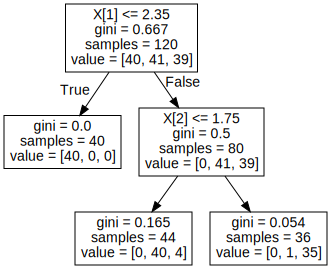

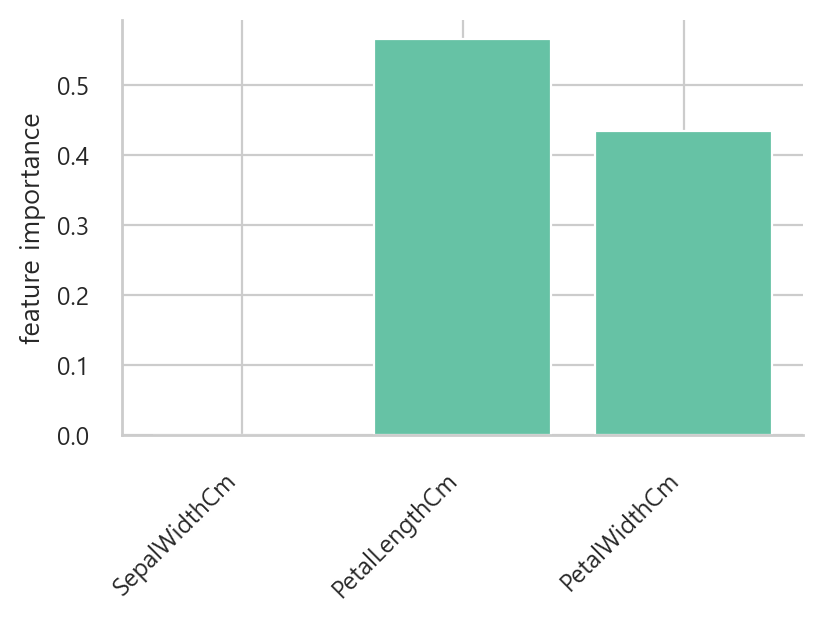

In [6]:
fig,ax = plt.subplots(figsize=(4,3))

ax.bar(iris.columns[1:-1], model_dt.feature_importances_)
ax.spines[["top","right"]].set_visible(False)
ax.set(ylabel = "feature importance")

plt.setp(ax.get_xticklabels(),ha="right", rotation = 45);
graphviz.Source(export_graphviz(model_dt))

## 교차 검증
- k - fold cross validation   
- k 등분한 교차검증 ( 5 또는 10을 많이씀)
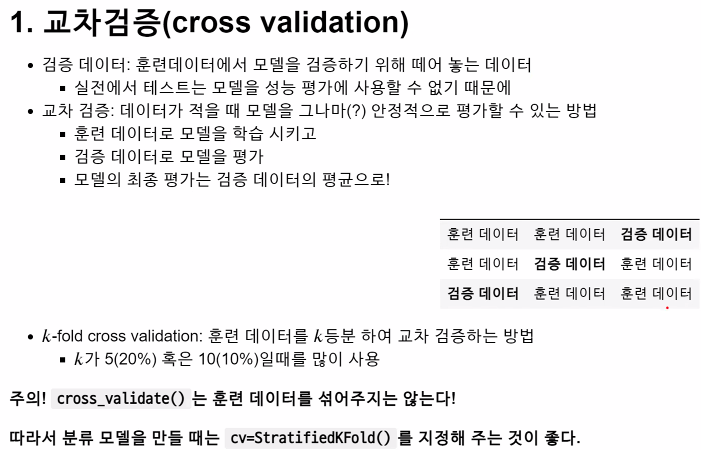

cv = StratifiedKFold() 를 지정해주면 섞어줌

In [7]:
x_train
y_train

Id
49         Iris-setosa
53     Iris-versicolor
83     Iris-versicolor
141     Iris-virginica
27         Iris-setosa
            ...       
32         Iris-setosa
40         Iris-setosa
59     Iris-versicolor
72     Iris-versicolor
126     Iris-virginica
Name: Species, Length: 120, dtype: object

#### 이렇게 보다

In [8]:
score = cross_validate(estimator=model_dt,
                       X = x_train,
                       y = y_train,
                       cv = 5)

score["test_score"]

array([0.95833333, 0.91666667, 1.        , 0.91666667, 0.91666667])

#### 이렇게 해야한다. StratifiedKFold 이용

In [9]:
score_strat = cross_validate(estimator=model_dt,
                       X = x_train,
                       y = y_train,
                       cv = StratifiedKFold(5,shuffle=True,random_state=42))

score_strat["test_score"] == score["test_score"]

array([ True, False,  True,  True, False])

In [10]:
score_strat_10fold = cross_validate(estimator=model_dt,
                       X = x_train,
                       y = y_train,
                       cv = StratifiedKFold(10,shuffle=True,random_state=42))

score_strat_10fold["test_score"]

array([1.        , 0.91666667, 0.66666667, 0.83333333, 1.        ,
       1.        , 0.91666667, 0.83333333, 1.        , 1.        ])

## 그리드 서치

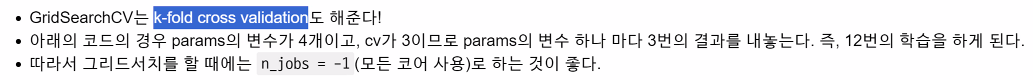

In [11]:
params = {"max_depth" : [3,4,5,10]}

base_model = DecisionTreeClassifier(random_state=209)
grid_model = GridSearchCV(base_model,
                          params, cv = StratifiedKFold(3,shuffle=True, random_state = 209), # cv 밸리데이션
                          return_train_score=True,
                          n_jobs = -1)

grid_model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=209, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=209), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 10]}, return_train_score=True)

In [21]:
# 파라미터마다 교차 검증 결과
grid_model.best_index_

0

In [19]:
grid_model.best_params_

{'max_depth': 3}

In [14]:
grid_model.best_score_

0.9416666666666668

### 결과가 가장 좋은 모델 찾기

In [22]:
best_model_dt = grid_model.best_estimator_
y_pred = best_model_dt.predict(x_test)

metrics.accuracy_score(y_pred , y_test)

0.9333333333333333

### 편하게 함수로 넣어서 해도 된다.

In [16]:

def grid_search(params,model_base = DecisionTreeClassifier(random_state=209)):
    model_base = GridSearchCV(base_model,
                              params,
                              cv = 3,
                              return_train_score=True,
                              n_jobs = -1)

    model_base.fit(x_train, y_train)

    print("최상 매개변수:", grid_model.best_params_)
    print("최고 정확도:", grid_model.best_score_)
    
    best_model = model_base.best_estimator_
    best_pred = best_model.predict(x_test)
    print("최고 정확도", metrics.accuracy_score(best_pred,y_test))


    return model_base.cv_results_

params = {"max_depth" : [1,2,4,10],
          "min_samples_leaf" : [3,4,5,10],
          "criterion" : ["gini","entropy"],}

_ = grid_search(params)

최상 매개변수: {'max_depth': 3}
최고 정확도: 0.9416666666666668
최고 정확도 0.9666666666666667


In [17]:
_["param_max_depth"].__len__() * 3 #cv 수

96

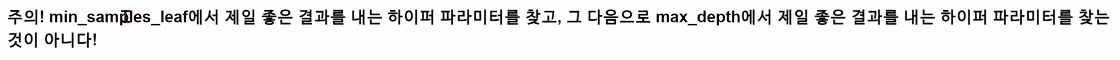

### 3

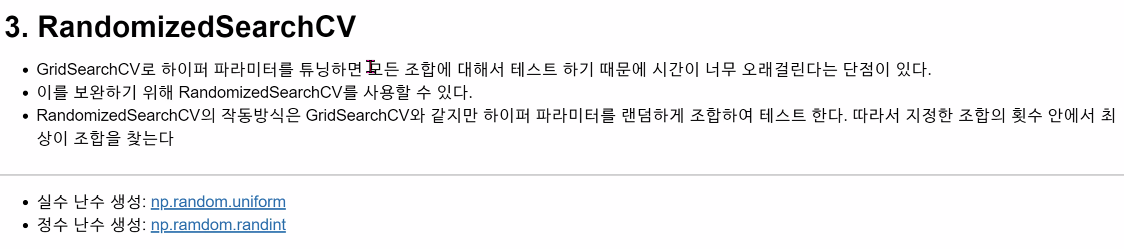

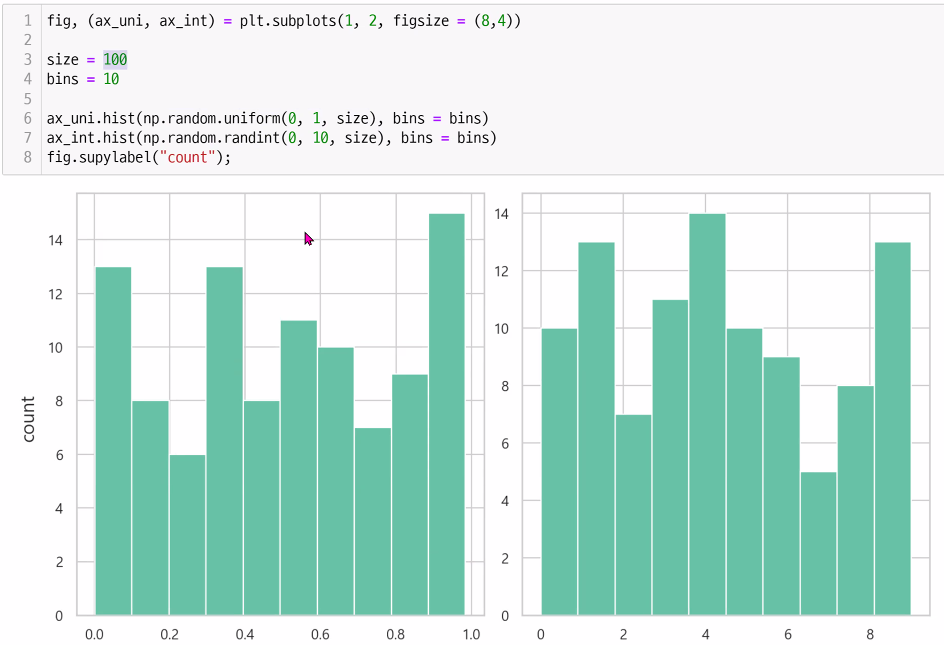

In [27]:
params = {"max_depth" : np.random.randint(1,10,10),
            "min_impurity_decrease" : np.random.uniform(0.001, 0.01, 30),
            "min_samples_leaf" : np.random.randint(1,10,10),
            "criterion" : ["gini","entropy"],}

base_model = DecisionTreeClassifier(random_state=209) # 그리드 서치에 집어넣을 모델을 지정한다.

grid_model = RandomizedSearchCV(base_model,
                                params,
                                n_iter=10,
                                cv = StratifiedKFold(3,shuffle=True, random_state = 209), # k-fold cross validation 을 입력한다.
                                return_train_score=True, # 훈련 데이터에 대한 스코어를 내보내는가를 나타낸다.
                                n_jobs = -1)

grid_model.fit(x_train, y_train)
grid_model.cv_results_ # 파라미터마다의 교차검증 결과를 보여준다.

{'mean_fit_time': array([0.00200089, 0.00266751, 0.00266735, 0.00200129, 0.00266655,
        0.00233412, 0.00266719, 0.00200033, 0.00200009, 0.00333468]),
 'std_fit_time': array([1.12391596e-07, 4.71932472e-04, 4.70639899e-04, 7.78671819e-07,
        4.72944197e-04, 4.71707890e-04, 4.71708533e-04, 5.84003864e-07,
        1.21570099e-06, 4.71595298e-04]),
 'mean_score_time': array([0.00133379, 0.00133363, 0.00200089, 0.00133332, 0.0016671 ,
        0.00166663, 0.00133395, 0.00200137, 0.00199962, 0.00099985]),
 'std_score_time': array([4.71145571e-04, 4.71427042e-04, 6.25769923e-07, 4.69798323e-04,
        9.42516105e-04, 4.71426560e-04, 4.72045065e-04, 2.97360213e-07,
        8.48537942e-07, 2.24783192e-07]),
 'param_min_samples_leaf': masked_array(data=[2, 7, 2, 5, 1, 8, 2, 5, 2, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_impurity_decrease': masked_arr

In [18]:
# 그리드 서치와 다르게 랜덤하게 뽑아서 iter 만큼 횟수를 한다.


def ran_search(params,iters,model_base = DecisionTreeClassifier(random_state=209)):
    model_base = RandomizedSearchCV(base_model,
                              params,
                              n_iter= iters,
                              cv = 3,
                              return_train_score=True,
                              n_jobs = -1,
                              random_state=97)

    model_base.fit(x_train, y_train)

    print("최상 매개변수:", grid_model.best_params_)
    print("최고 정확도:", grid_model.best_score_)
    
    best_model = model_base.best_estimator_
    best_pred = best_model.predict(x_test)
    print("최고 정확도", metrics.accuracy_score(best_pred,y_test))


    return model_base.cv_results_

params = {
            "max_depth" : np.random.randint(1,10,10),
          "min_impurity_decrease" : np.random.uniform(0.001, 0.01, 30),
          "min_samples_leaf" : np.random.randint(1,10,10),
          "criterion" : ["gini","entropy"],
          }

_ = ran_search(params,50)
_

최상 매개변수: {'max_depth': 3}
최고 정확도: 0.9416666666666668
최고 정확도 0.9333333333333333


{'mean_fit_time': array([0.00166647, 0.00233444, 0.00200105, 0.00200113, 0.00200025,
        0.00183606, 0.00250443, 0.00200065, 0.00217183, 0.00200049,
        0.0023342 , 0.00300058, 0.00200049, 0.00233364, 0.0019997 ,
        0.00166694, 0.00200049, 0.00200089, 0.00233396, 0.00200033,
        0.00200041, 0.00200041, 0.00233412, 0.00200057, 0.00400114,
        0.00233356, 0.00200081, 0.0023338 , 0.00233436, 0.00300034,
        0.00266695, 0.00266743, 0.00233412, 0.00266759, 0.00199978,
        0.00266743, 0.00233412, 0.00233459, 0.00233412, 0.00200049,
        0.00233412, 0.00283543, 0.00216897, 0.00200009, 0.00200081,
        0.00166718, 0.00200033, 0.00200025, 0.00200073, 0.00200041]),
 'std_fit_time': array([4.71482745e-04, 4.71314168e-04, 1.59342588e-06, 2.24783192e-07,
        5.94720425e-07, 2.32650685e-04, 4.08537330e-04, 4.89903609e-07,
        2.39848722e-04, 1.12391596e-07, 4.71819960e-04, 8.16340302e-04,
        4.89903609e-07, 4.71876206e-04, 4.49566384e-07, 4.71482745e-0

### ensemble

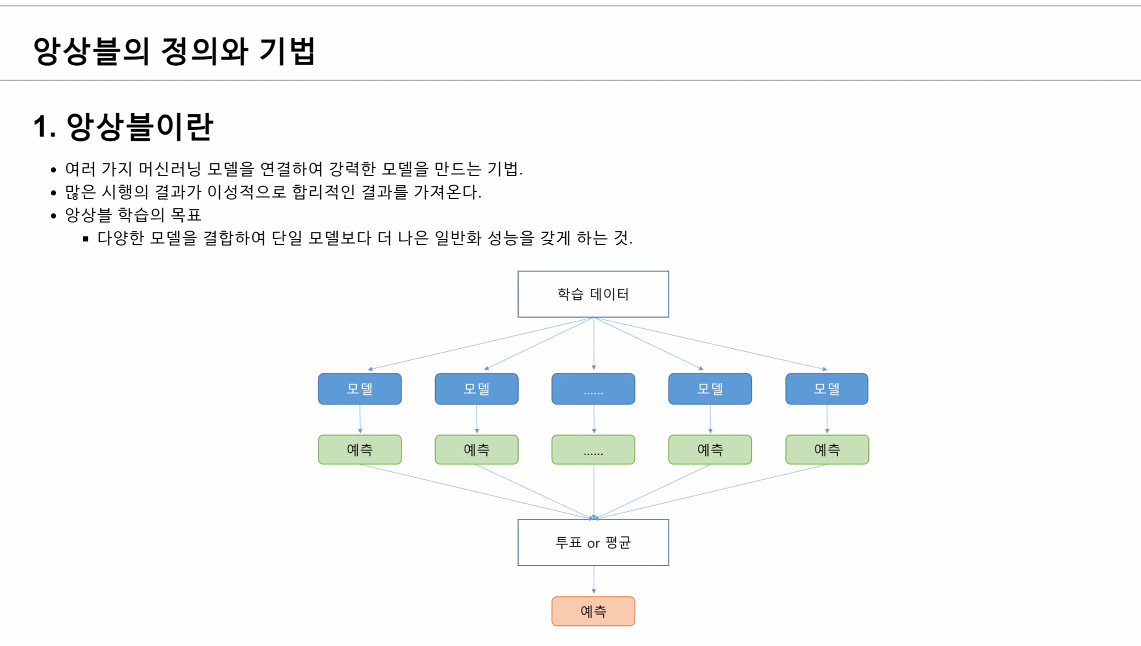

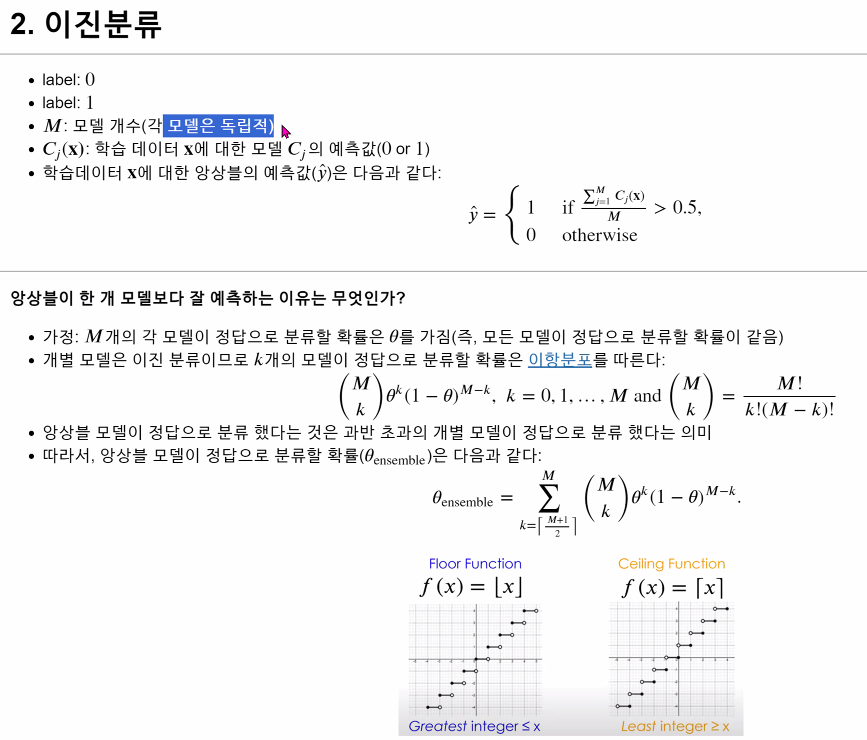

#### 실링 의 의미 : 그 수보다 큰 가장 작은 정수

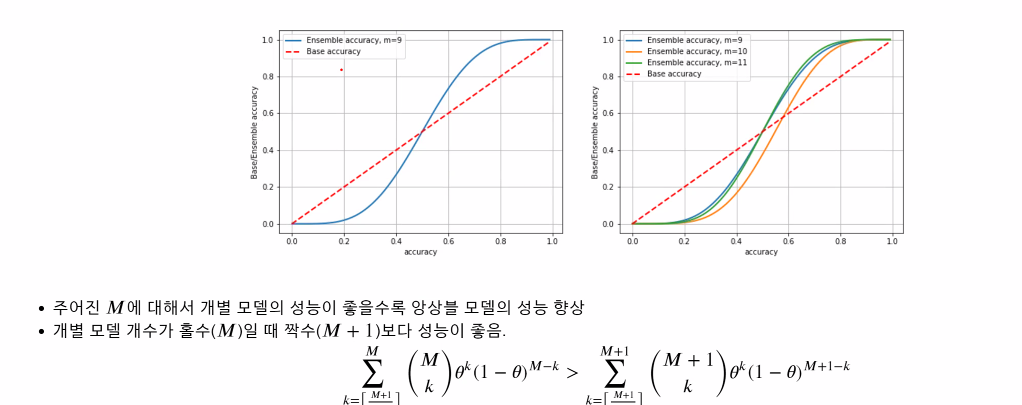

즉 앙상블 모델을 쓸거면 최소한 반이상은 맞추는 모델을 써야한다.

개별 모델이 맞출 확률이 0.5 보다 좋으면 앙상블 모델 성능이 좋아진다.
그리고 홀수일때 짝수일때보다 좀더 성능이 좋다.

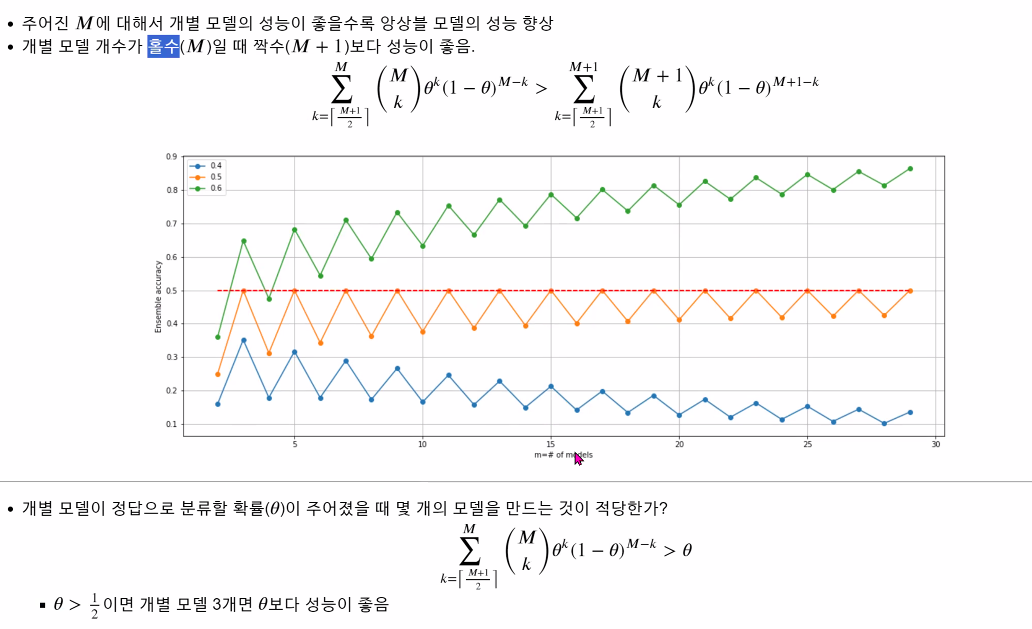

#### 상상블의 다양한 기법들

##### bagging (bootstrap aggregating)
- sklearn bagging classifier
- bootstraps

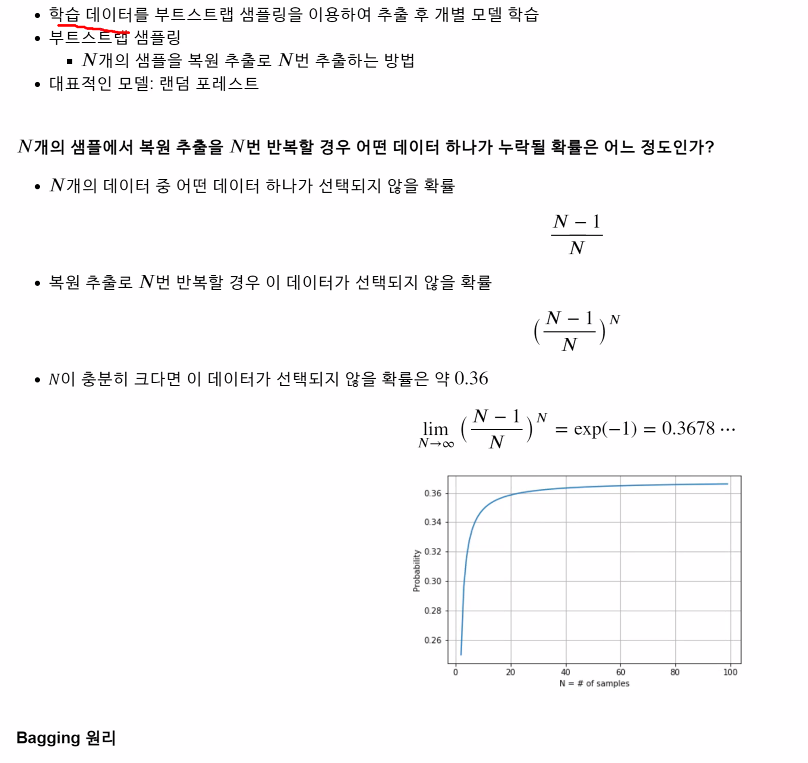

100개의 샘플이 있으면 하나씩 뽑고 다시집어넣는 방법을 100번한다. : 부트스트랩\
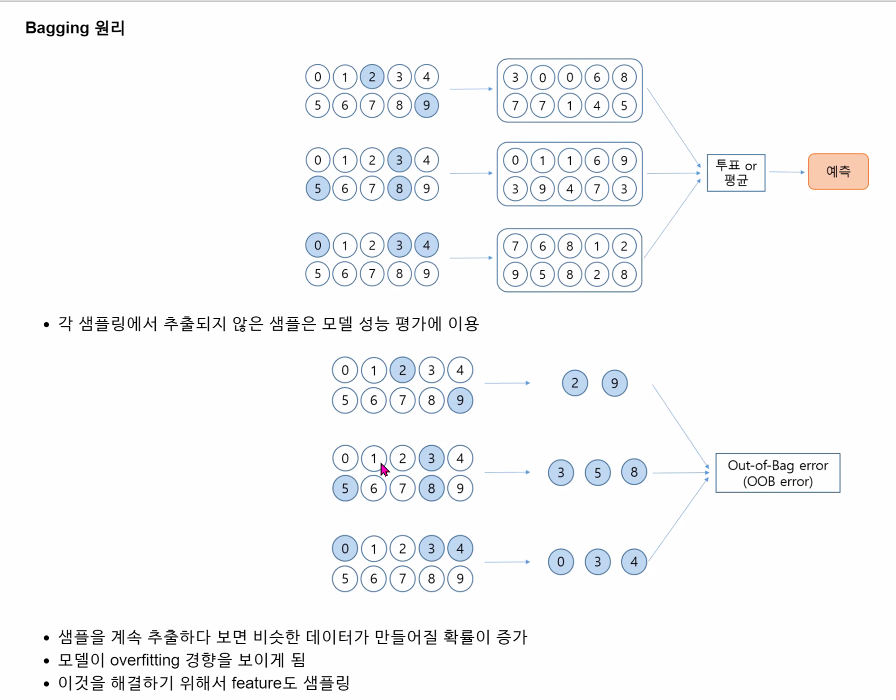

OOB 뽑히지 않은 샘플에 대해서 모델이 어느정도의 성능을 갖는가를 구할 수있다.

모델의 오버피팅 경향이 있기 떄문에
피쳐자체도 샘플링한다.

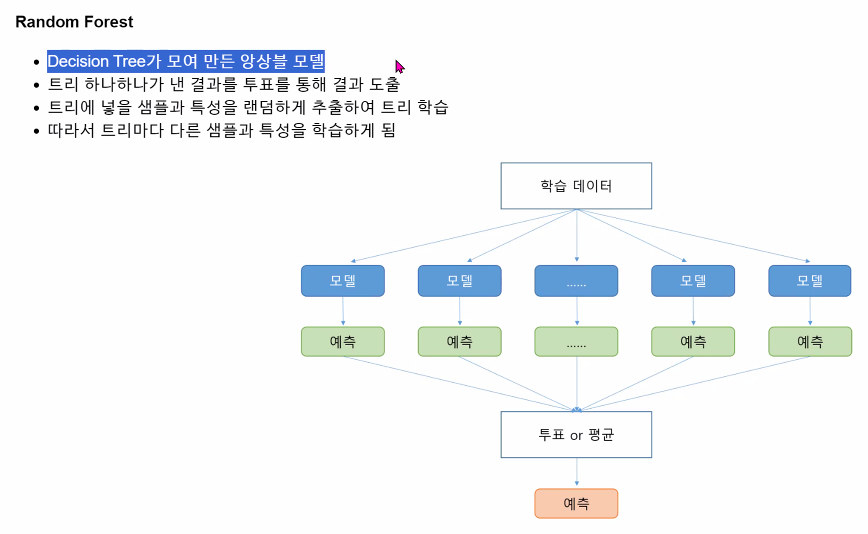